In [1]:
# system preparation
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = [11, 7]
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.linewidth'] = 2.0
plt.rcParams['lines.linewidth'] = 1.0
colors = ['r','green','b','m','darkorange','cyan','lime']

# 2 to 5 charge state simulation and extract all charge states data

In [2]:
### import flame module
from flame import Machine

In [3]:
### specify lattice file location
lat_file = "LS1FS1_lattice.lat"

In [4]:
### read lattice file in
with open(lat_file, 'rb') as inf:
        # create lattice data object M
        M = Machine(inf)

In [5]:
### Initialize simulation parameters
# states
S = M.allocState({})

In [6]:
### run flame; 
# 0, len(M); beginnig to end of the lattice
# observe=range(len(M)); return states data at each element
# propagation results assigned to 'results' 
results = M.propagate(S, 0, len(M), observe=range(0,len(M)))

## - Plot energy history

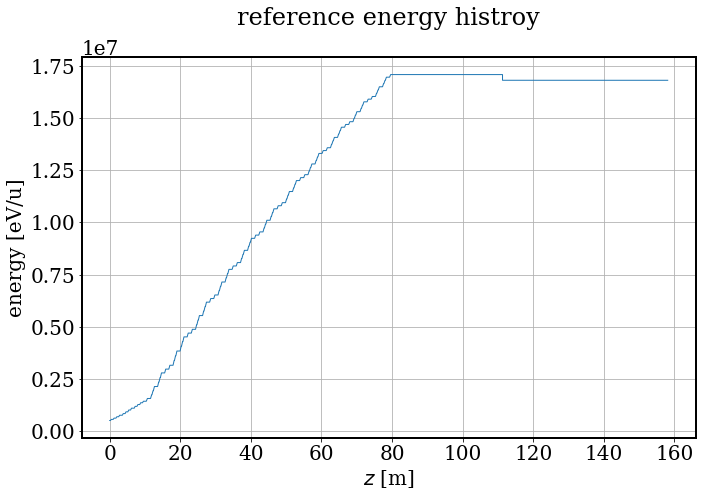

In [7]:
### plot energy
# extract from 'results'
pos = [results[i][1].pos for i in range(len(M))]
ek = [results[i][1].ref_IonEk for i in range(len(M))]
# plot reference energy
plt.plot(pos,ek)
plt.title('reference energy histroy\n')
plt.xlabel('$z$ [m]')
plt.ylabel('energy [eV/u]')
plt.show()

## - plot x, y centroid and rms  of overall beam

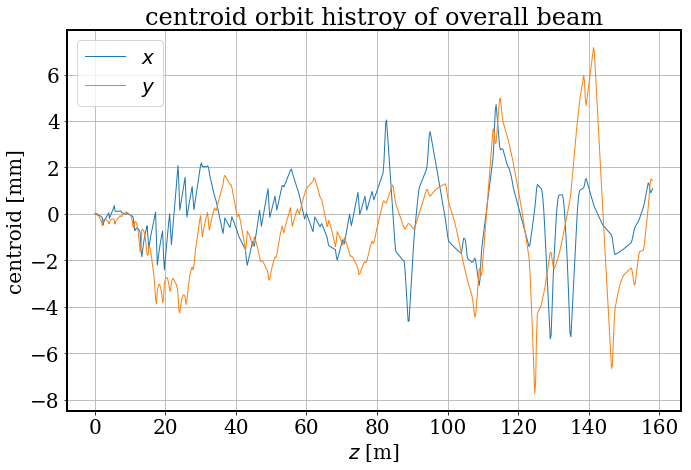

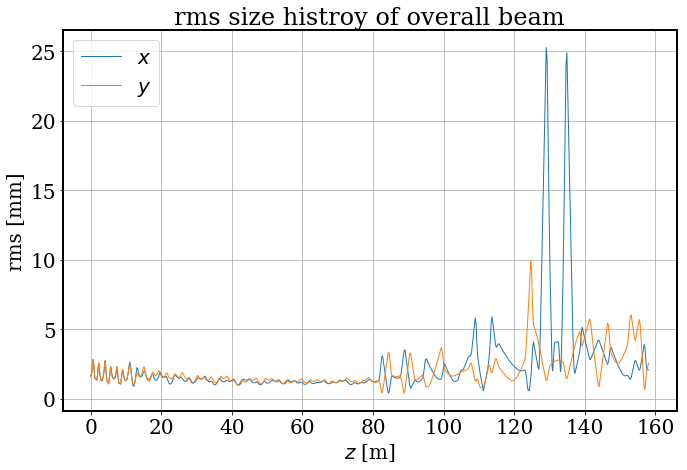

In [8]:
### plot x, y centroid and rms  of overall beam
# extract from 'results'
pos = [results[i][1].pos for i in range(len(M))]
x,y = np.array([[results[i][1].moment0_env[j] for i in range(len(M))] for j in [0,2]])
xrms,yrms = np.array([[results[i][1].moment0_rms[j] for i in range(len(M))] for j in [0,2]])

# plot x,y centroid
plt.plot(pos,x,label='$x$')
plt.plot(pos,y,label='$y$')
plt.title('centroid orbit histroy of overall beam')
plt.xlabel('$z$ [m]')
plt.ylabel('centroid [mm]')
plt.legend(loc='best')
plt.show()

# plot x, y rms
plt.plot(pos,xrms,label='$x$')
plt.plot(pos,yrms,label='$y$')
plt.title('rms size histroy of overall beam')
plt.xlabel('$z$ [m]')
plt.ylabel('rms [mm]')
plt.legend(loc='upper left')
plt.show()

## - python object data are easy to manage

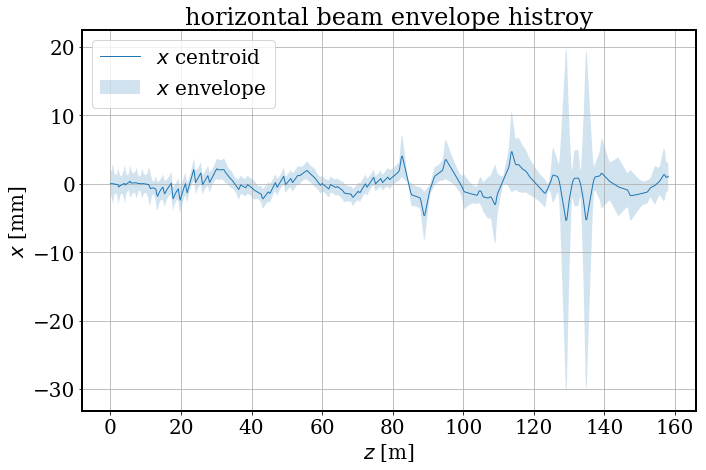

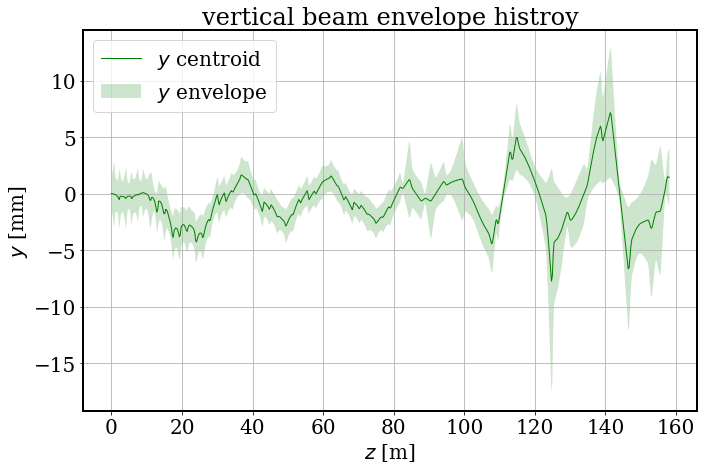

In [9]:
### python object data are easy to manage
# plot x centroid and rms
plt.plot(pos,x,label='$x$ centroid')
plt.fill_between(pos, x+xrms, x-xrms, alpha=0.2, label='$x$ envelope')
plt.title('horizontal beam envelope histroy')
plt.xlabel('$z$ [m]')
plt.ylabel('$x$ [mm]')
plt.legend(loc='upper left')
plt.show()

# plot y centroid and rms
plt.plot(pos,y,'g',label='$y$ centroid')
plt.title('vertical beam envelope histroy')
plt.fill_between(pos, y+yrms, y-yrms,facecolor='g', alpha=0.2, label='$y$ envelope')
plt.xlabel('$z$ [m]')
plt.ylabel('$y$ [mm]')
plt.legend(loc='upper left')
plt.show()

## - plot beam envelope of each charge state

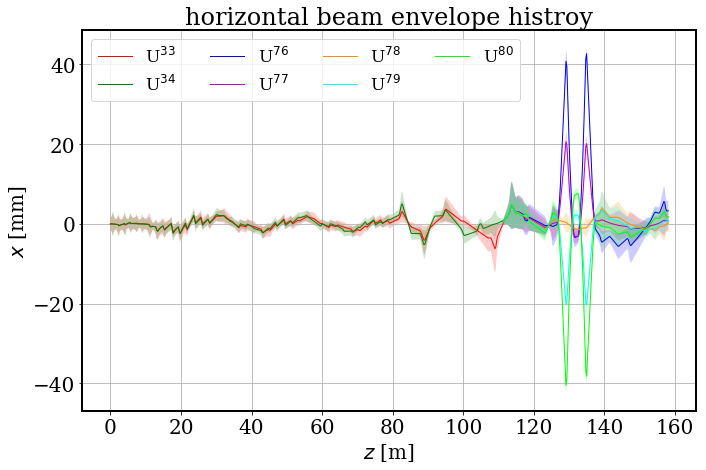

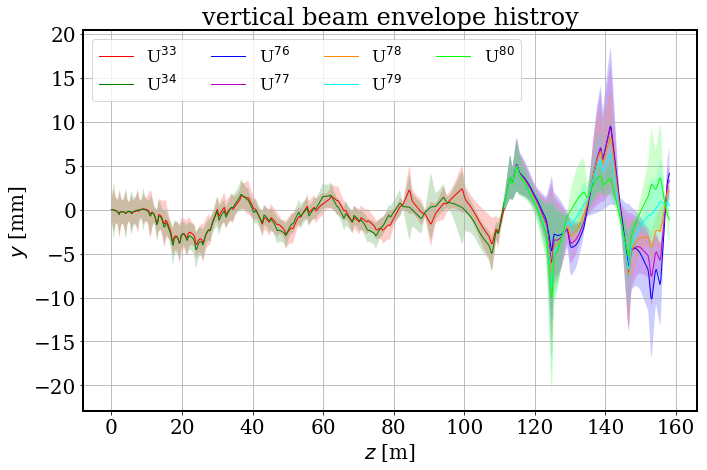

In [11]:
### plot RMS x, y  of each charge state
# extract from results
n_i = len(M.conf()['IonChargeStates'])
n_s = len(M.conf()['Stripper_IonChargeStates'])

pos, x, y, xrms, yrms = [[[] for _ in range(n_i+n_s)] for _ in range(5)]

for i in range(len(M)):
    j,o = [n_i,0] if n_i == len(results[i][1].IonZ) else [n_s,n_i]        
    for k in range(j):
        pos[k+o].append(results[i][1].pos)
        x[k+o].append(results[i][1].moment0[0,k])
        y[k+o].append(results[i][1].moment0[2,k])
        xrms[k+o].append(np.sqrt(results[i][1].moment1[0,0,k]))
        yrms[k+o].append(np.sqrt(results[i][1].moment1[2,2,k]))

        
# plot x centroid and rms
cs = ['33','34','76','77','78','79','80']
for i in range(n_i + n_s):
    plt.plot(pos[i],x[i],color=colors[i],label='U$^{'+cs[i]+'}$')
    plt.fill_between(pos[i],np.array(x[i])+np.array(xrms[i]),
                            np.array(x[i])-np.array(xrms[i]),
                     alpha=0.2,facecolor=colors[i])
    
plt.title('horizontal beam envelope histroy')
plt.xlabel('$z$ [m]')
plt.ylabel('$x$ [mm]')
plt.legend(loc = 'upper left', ncol = 4, fontsize=17)
plt.show()

# plot y centroid and rms
for i in range(n_i + n_s):
    plt.plot(pos[i],y[i],color=colors[i],label='U$^{'+cs[i]+'}$')
    plt.fill_between(pos[i],np.array(y[i])+np.array(yrms[i]),
                            np.array(y[i])-np.array(yrms[i]),
                     alpha=0.2,facecolor=colors[i])
plt.title('vertical beam envelope histroy')
plt.xlabel('$z$ [m]')
plt.ylabel('$y$ [mm]')
plt.legend(loc = 'upper left', ncol = 4, fontsize=17)
plt.show()

------------
# Advanced usage
### Simulate up to point A and repeat from A to B simulation with changing lattice parameter

<img src="demo2.png">

In [12]:
# index of point A (solenoid:ls1_cb06_sol3_d1594_47)
point_A = [i for i in range(len(M)) if M.conf(i)['name']=='ls1_cb06_sol3_d1594_48'][0]

# Simulate from initial point(LS1 entrance) to point A 
S2 = M.allocState({})
resultsA = M.propagate(S2, 0, point_A-1, observe = range(point_A))

### Simulate from A to B(FS1 exit) with changing solenoid strength
# Try 3 Bz [T] cases for the solenoid
bzcase = [5.0, 7.5, 10.0] 
# make array for results
resultsB = [[] for _ in range(len(bzcase))]
for i,bz in enumerate(bzcase):
    # Set new solenoid parameter
    M.reconfigure(point_A,{'B': bz})

    # clone beam parameter of point S 
    S3 = S2.clone()
    
    # Simulate from A to B and store results
    end_B = len(M)
    resultsB[i] = M.propagate(S3, point_A, end_B, observe = range(end_B))

## - plot beam envelope for 3 Bz cases

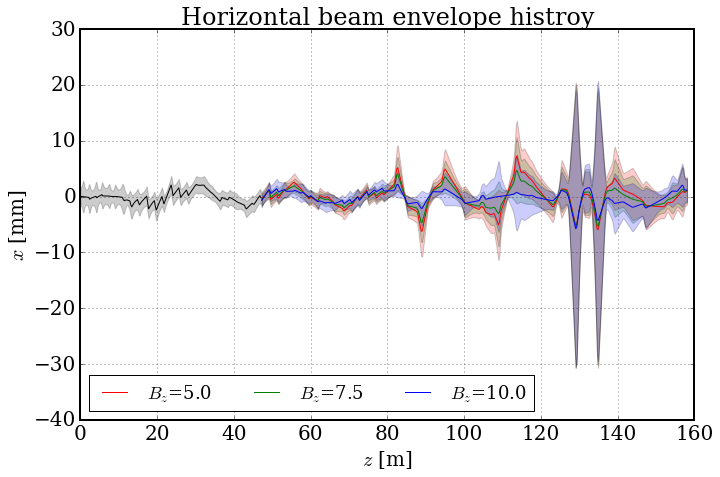

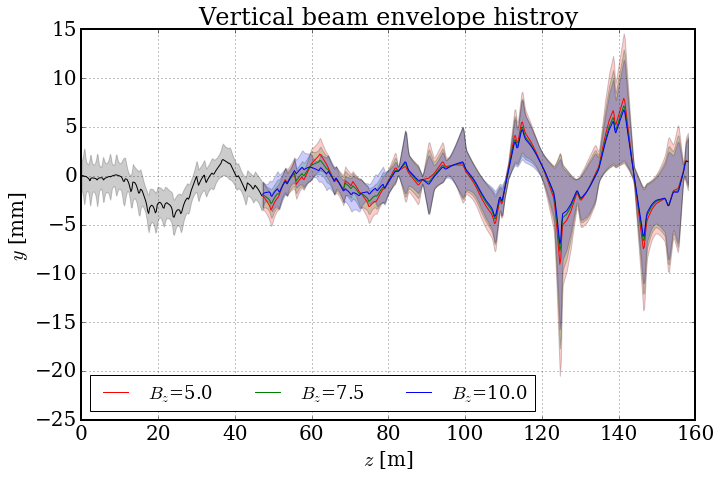

In [13]:
# extract from results
pos_A = [resultsA[i][1].pos for i in range(point_A-1)]
x_A,y_A = np.array([[resultsA[i][1].moment0_env[j] for i in range(point_A-1)] for j in [0,2]])
xrms_A,yrms_A = np.array([[resultsA[i][1].moment0_rms[j] for i in range(point_A-1)] for j in [0,2]])

dlen = len(resultsB)
pos_B, x_B, y_B, xrms_B, yrms_B = [[[] for _ in range(dlen)] for _ in range(5)]

for k in range(3):
    clen = len(resultsB[k])
    pos_B[k] = [resultsB[k][i][1].pos for i in range(clen)]
    x_B[k], y_B[k] = np.array([[resultsB[k][i][1].moment0_env[j] for i in range(clen)] for j in [0,2]])
    xrms_B[k], yrms_B[k] = np.array([[resultsB[k][i][1].moment0_rms[j] for i in range(clen)] for j in [0,2]])

    
# plot x centroid and rms
plt.plot(pos_A,x_A,'k')
plt.fill_between(pos_A, x_A+xrms_A, x_A-xrms_A, facecolor='k',alpha=0.2)
for k in range(dlen):
    plt.plot(pos_B[k], x_B[k], color=colors[k], label='$B_z$='+str(bzcase[k]))
    plt.fill_between(pos_B[k], x_B[k]+xrms_B[k], x_B[k]-xrms_B[k], facecolor=colors[k], alpha=0.2)
plt.title('Horizontal beam envelope histroy')
plt.xlabel('$z$ [m]')
plt.ylabel('$x$ [mm]')
plt.legend(loc='lower left', ncol = 3, fontsize=18)
plt.show()
    
    
# plot y centroid and rms
plt.plot(pos_A,y_A,'k')
plt.fill_between(pos_A, y_A+yrms_A, y_A-yrms_A, facecolor='k',alpha=0.2)
for k in range(dlen):
    plt.plot(pos_B[k],y_B[k], color=colors[k], label='$B_z$='+str(bzcase[k]))
    plt.fill_between(pos_B[k], y_B[k]+yrms_B[k], y_B[k]-yrms_B[k], facecolor=colors[k], alpha=0.2)
plt.title('Vertical beam envelope histroy')
plt.xlabel('$z$ [m]')
plt.ylabel('$y$ [mm]')
plt.legend(loc='lower left', ncol = 3, fontsize=18)
plt.show()